# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, i will be working to understand the results of an A/B test run by an e-commerce website.  my goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.



<a id='probability'></a>
## Part I - Probability



In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#reading the csv file into a dataframe
df = pd.read_csv('./ab_data.csv')


In [4]:
#displaying the dataframe to understand it better
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
df['landing_page'].value_counts()

new_page    147239
old_page    147239
Name: landing_page, dtype: int64

In [6]:
df['group'].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

### ToDo 1.1
 `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>



**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

**b.** Use the cell below to find the number of rows in the dataset.

In [7]:
#find the rows and columns of the dataframe
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [8]:
#choosing the unique values of user_id in order to find the unique users for the dataframe
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [9]:
#dividing the number of converted users over the number of unique users to find the proportion of users converted
df.query('converted == 1')['converted'].count()/df['user_id'].nunique()

0.12126269856564711

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [10]:
#the number of times the group is treatment but landing page is old page
df[(df['group'] == 'treatment')&(df['landing_page'] != 'new_page')].shape[0]

1965

In [11]:
#the number of times the group is control but the landing page is new page
df[(df['group'] == 'control')&(df['landing_page'] != 'old_page')].shape[0]

1928

In [12]:
#adding up the two numbers to find the number of mismatched rows
1965 + 1928

3893

**f.** Do any of the rows have missing values?

In [13]:
#using the isnull function to find null cells and summing it to find out how many columns have how many null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  





In [14]:
# Remove the inaccurate rows, and store the result in a new dataframe df2


In [15]:
#creating a dataframe of times treatment and old page match
dff1 = df[(df['group'] == 'treatment')&(df['landing_page'] != 'new_page')]

In [16]:
#creating a dataframe of times control and new page match
dff2 = df[(df['group'] == 'control')&(df['landing_page'] != 'old_page')]

In [17]:
#appending them together to have one dataframe that have all the incorrect rows
dff1 = dff1.append(dff2)

In [18]:
#dropping all the incorrect rows from the dataframe and keeping the correct ones in a new dataframe
df2 = df.drop(dff1.index,axis =0)

In [19]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  


**a.** How many unique **user_id**s are in **df2**?

In [20]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [21]:
#using the duplicated function to find out the duplicated user_ids
df2dup = df2.duplicated('user_id')

In [22]:
df2[df2dup]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [23]:
#only one duplicate user id 
df2dup.value_counts()

False    290584
True          1
dtype: int64

In [24]:
#finding out the duplicated user id value
df2[df2dup]['user_id']

2893    773192
Name: user_id, dtype: int64

In [25]:
#saving the duplicated row in a variable
dup_row = df2[df2dup]

**c.** Display the rows for the duplicate **user_id**? 

In [26]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [27]:
# Remove one of the rows with a duplicate user_id..
df2.drop(dup_row.index,axis=0,inplace=True)


In [28]:
df2.duplicated('user_id').value_counts()

False    290584
dtype: int64

### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>




In [29]:
#getting the mean of converted will give us the propability of convertion
df2['converted'].mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [30]:
#choosing the control rows with query and then getting the mean
PropC = (df2.query('group == "control"')['converted']==1).mean()

In [31]:
PropC

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [32]:
#choosing the treatment rows with query and hen getting the mean
PropT = (df2.query('group == "treatment"')['converted']==1).mean()

In [33]:
PropT

0.11880806551510564

In [34]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.

In [73]:
obs_diff = PropT - PropC

**d.** What is the probability that an individual received the new page?

In [61]:
#dividing the number of times landing page is new page by the number of all rows
df2[df2['landing_page'] == "new_page"]['landing_page'].count()/df2.shape[0]

0.50006194422266881

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

**The probability of converting for both control and treatment group is: 11.95%**

**The probability of converting for the control group who receives the old page is: 12.04%**

**The probability of converting for the treatment group who receives the new page is: 11.88%**

**while the old page seems to do better for converting the difference is small enough that we cannot truely be sure.**


<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**$p_{new}$** - **$p_{old}$** **<=0** **$H_0$** 



> **$p_{new}$** - **$p_{old}$** **>0** **$H_1$**

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 





**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [62]:
#p new = p old = p population so we just get the population mean 
p_new= df2['converted'].mean()

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [63]:
p_old = df2['converted'].mean()

In [64]:
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [65]:
#finding all rows with treatment in group column and counting them
n_new = df2.query('group == "treatment"')['user_id'].count()

In [66]:
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [67]:
#finding all rows with control in group column and counting them
n_old = df2.query('group == "control"')['user_id'].count()

In [68]:
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>



In [44]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1,0],size=n_new,p=[p_new,1-p_new],replace=True)
new_page_converted.mean()

0.11857408299497625

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [45]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1,0],size=n_old,p=[p_old,1-p_old] , replace=True)
old_page_converted.mean()

0.12174924625191018

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [46]:
diff = new_page_converted.mean() - old_page_converted.mean() 


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [47]:
# Sampling distribution 
p_diffs = []
#calculating the difference in means ten thousand times and appending it to the p_diff var
for _ in range(10000):
    new_con =  np.random.choice([1,0],size=n_new,p=[p_new,1-p_new])
    old_con =  np.random.choice([1,0],size=n_old,p=[p_old,1-p_old])
    dif = new_con.mean() - old_con.mean()
    p_diffs.append(dif)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  



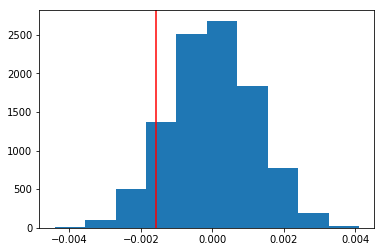

In [74]:
plt.hist(p_diffs);
plt.axvline(obs_diff,c='red');

In [75]:
#transforming p_diff into an array
p_diffs = np.array(p_diffs)

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [76]:
#creating a normal distribution around 0 with the stand deviation and size of the sampling distribution
null_vals = np.random.normal(0,p_diffs.std(),p_diffs.size)




In [77]:
#calulation the p value
p_value = (null_vals>obs_diff).mean()
p_value

0.90820000000000001

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? 

>**What we computed was the p_value which we rely on to determine the statistical significance of our finding.**
with a type 1 error rate of 0.05 we compare this error rate with the p value
to find that p_value is bigger than the type 1 error rate 
0.908>0.05
so we fail to reject the null hypothesis 
which means that the old page has the same or better convertion rate than the new page




**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [53]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = (df2.query('group == "control"')['converted']==1).sum()

# number of conversions with the new_page
convert_new = (df2.query('group == "treatment"')['converted']==1).sum()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"')['user_id'].count()

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

In [55]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old,n_new], alternative='smaller')
print(z_score, p_value)

1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>



**z-score is 1.31 and Za is 1.64**

**our test is right tailed so checking Z-score > Za ? 1.13 > 1.64 ?**


**that's false so that means we fail to reject the null which is the same conclusion we reached from the previous p-value test.**

**newly calculated p-value is 0.905 which is larger than the type i error rate of 0.05**

**so this also tells us that we fail to reject the null hypothesis which means the old page has the same or better conversion rate than the new page**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**logistic regression.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [54]:
#getting two columns from group column control and treatment and renaming treatment to ab_page
df2[['control','ab_page']]  = pd.get_dummies(df2['group'])

In [55]:
#dropping the control column since it's not needed
df2.drop(['control'], axis = 1,inplace=True)

In [56]:
#creating the intercept column
df2['intercept'] = 1

In [57]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [58]:
#defining the dependant(Y) and explanatory(X)
y = df2['converted']
x = df2[['intercept','ab_page']]

#fitting the model
log_mod = sm.Logit(y,x)
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [59]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-14 22:02 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  



**the p value associated with ab_page is 0.1899 which means it is not statistically significant
since it's bigger than the type 1 error rate of 0.05.**

**the reason the p value differs from the one in part II because in part II the test was one sided
however in our regression module it's a two sided test**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**adding more factors into the regression model may increase accuracy but, the disadvantage would be complex readabiliy.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`.

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [60]:
# Read the countries.csv

df3 = pd.read_csv('./countries.csv')
df3.head()


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [61]:
# Join with the df2 dataframe
df2 = df2.set_index('user_id').join(df3.set_index('user_id'))
df2.head()

,timestamp,group,landing_page,converted,ab_page,intercept,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [62]:
# Create the necessary dummy variables
df2[['CA','UK','US']]  = pd.get_dummies(df2['country'])


In [63]:
df2.head()

,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1


In [64]:
# Fit your model, and summarize the results
y = df2['converted']
x = df2[['intercept','ab_page' ,'CA','UK']]

log_mod = sm.Logit(y,x)
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [65]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-14 22:03 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

**h. Fit your model and obtain the results**<br> 

**after reading the p values the regression module we can say that none of our coeffiencts are statistically significant**


Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 



In [66]:
#creating higher order terms
#new columns
df2['CA_page'] = df2['ab_page'] * df2['CA']
df2['UK_page'] = df2['ab_page'] * df2['UK']

df2.head()

,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US,CA_page,UK_page
user_id,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1,0,0


In [67]:
y = df2['converted']
x = df2[['intercept','ab_page' ,'CA','UK','CA_page','UK_page']]

log_mod = sm.Logit(y,x)
result = log_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-14 22:03 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_page      -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_page       0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

>**the p values associated with all the coefficient informs us that none of them are statistically significant
not only that but using higher order terms negatively affected the p values of CA and UK so we should not have included them .**
>**this means we have no evidence to suggest that the new page is better than the old page for converting users**

In [78]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0